# PostgreSQL + pgvector 벡터 데이터베이스 실습

이 노트북에서는 PostgreSQL의 pgvector 확장을 사용하여 벡터 데이터베이스를 구현하고 활용하는 방법을 학습합니다.

## 주요 특징
- **PostgreSQL + pgvector**: 오픈소스 관계형 데이터베이스와 벡터 확장의 조합
- **ACID 트랜잭션**: 완전한 트랜잭션 지원으로 데이터 일관성 보장
- **다양한 거리 함수**: L2, 내적, 코사인 유사도 지원
- **고성능 인덱스**: IVFFlat, HNSW 인덱스로 빠른 근사 검색
- **SQL 호환성**: 표준 SQL과 벡터 연산을 함께 사용 가능

## 사전 요구사항
1. PostgreSQL 서버가 로컬 5432 포트에서 실행 중
2. pgvector 확장이 설치되어 있어야 함
3. 데이터베이스 생성 및 접근 권한

## 1. 필수 라이브러리 설치 및 임포트

In [2]:
# 이미 uv를 통해 패키지가 설치되었습니다.
# 필요한 패키지들을 확인해보겠습니다.

print("📦 패키지 확인 중...")

packages_status = {}

try:
    import psycopg2
    packages_status['psycopg2'] = "✅ 사용 가능"
except ImportError as e:
    packages_status['psycopg2'] = f"❌ 없음: {e}"

try:
    from pgvector.psycopg2 import register_vector
    packages_status['pgvector'] = "✅ 사용 가능"
except ImportError as e:
    packages_status['pgvector'] = f"❌ 없음: {e}"

try:
    import numpy as np
    packages_status['numpy'] = "✅ 사용 가능"
except ImportError as e:
    packages_status['numpy'] = f"❌ 없음: {e}"

try:
    import pandas as pd
    packages_status['pandas'] = "✅ 사용 가능"
except ImportError as e:
    packages_status['pandas'] = f"❌ 없음: {e}"

try:
    import matplotlib.pyplot as plt
    packages_status['matplotlib'] = "✅ 사용 가능"
except ImportError as e:
    packages_status['matplotlib'] = f"❌ 없음: {e}"

try:
    from sklearn.metrics.pairwise import cosine_similarity
    packages_status['scikit-learn'] = "✅ 사용 가능"
except ImportError as e:
    packages_status['scikit-learn'] = f"❌ 없음: {e}"

print("\n📋 패키지 상태:")
for package, status in packages_status.items():
    print(f"   {package}: {status}")

# 부족한 패키지가 있다면 추가 설치 안내
missing_packages = [pkg for pkg, status in packages_status.items() if "없음" in status]

if missing_packages:
    print(f"\n⚠️  부족한 패키지: {', '.join(missing_packages)}")
    print("💡 터미널에서 다음 명령어를 실행해주세요:")
    print(f"   cd /Users/judyda/AI_Study/VectorDB")
    print(f"   uv add {' '.join(missing_packages)}")
else:
    print("\n🎉 모든 필수 패키지가 준비되었습니다!")

📦 패키지 확인 중...

📋 패키지 상태:
   psycopg2: ✅ 사용 가능
   pgvector: ✅ 사용 가능
   numpy: ✅ 사용 가능
   pandas: ✅ 사용 가능
   matplotlib: ✅ 사용 가능
   scikit-learn: ✅ 사용 가능

🎉 모든 필수 패키지가 준비되었습니다!


In [3]:
# 필요한 라이브러리 임포트
import psycopg2
import numpy as np
import pandas as pd
from pgvector.psycopg2 import register_vector
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import random
import time
from typing import List, Tuple, Dict, Any

print("📚 라이브러리 임포트 완료!")
print("🔗 PostgreSQL 연결 준비 완료")
print("🧮 벡터 연산 라이브러리 로드 완료")

📚 라이브러리 임포트 완료!
🔗 PostgreSQL 연결 준비 완료
🧮 벡터 연산 라이브러리 로드 완료


## 2. PostgreSQL 연결 설정

In [4]:
# PostgreSQL 데이터베이스 연결 설정
DB_CONFIG = {
    'host': 'localhost',      # 로컬 호스트
    'port': 5432,             # PostgreSQL 기본 포트
    'database': 'vectordb',   # 데이터베이스 이름 (필요시 변경)
    'user': 'postgres',       # 사용자명 (필요시 변경)
    'password': 'password'    # 비밀번호 (실제 비밀번호로 변경 필요!)
}

def get_db_connection():
    """PostgreSQL 데이터베이스 연결을 생성하고 pgvector를 등록합니다."""
    try:
        # 데이터베이스 연결
        conn = psycopg2.connect(**DB_CONFIG)
        
        # pgvector 확장 등록
        register_vector(conn)
        
        return conn
    except psycopg2.Error as e:
        print(f"❌ 데이터베이스 연결 실패: {e}")
        return None
    except Exception as e:
        print(f"❌ 예상치 못한 오류: {e}")
        return None

# 연결 테스트
print("🔌 PostgreSQL 연결 테스트 중...")
test_conn = get_db_connection()

if test_conn:
    print("✅ PostgreSQL 연결 성공!")
    print(f"📍 연결 정보: {DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}")
    test_conn.close()
else:
    print("❌ PostgreSQL 연결 실패!")
    print("💡 확인사항:")
    print("   1. PostgreSQL 서버가 실행 중인지 확인")
    print("   2. 포트 5432가 열려있는지 확인") 
    print("   3. 데이터베이스와 사용자 계정이 존재하는지 확인")
    print("   4. 비밀번호가 올바른지 확인")

🔌 PostgreSQL 연결 테스트 중...
✅ PostgreSQL 연결 성공!
📍 연결 정보: localhost:5432/vectordb


## 3. pgvector 확장 활성화

In [5]:
def setup_pgvector_extension():
    """PostgreSQL에서 pgvector 확장을 활성화합니다."""
    conn = get_db_connection()
    if not conn:
        return False
    
    try:
        cursor = conn.cursor()
        
        # pgvector 확장 생성 (이미 존재하면 무시)
        cursor.execute("CREATE EXTENSION IF NOT EXISTS vector;")
        
        # 확장 확인
        cursor.execute("""
            SELECT extname, extversion 
            FROM pg_extension 
            WHERE extname = 'vector';
        """)
        
        result = cursor.fetchone()
        
        if result:
            print(f"✅ pgvector 확장 활성화 완료!")
            print(f"📦 확장 이름: {result[0]}")
            print(f"🏷️  버전: {result[1]}")
        else:
            print("❌ pgvector 확장을 찾을 수 없습니다.")
            return False
        
        # 확장 기능 테스트
        cursor.execute("SELECT '[1,2,3]'::vector;")
        test_vector = cursor.fetchone()[0]
        print(f"🧪 벡터 테스트: {test_vector}")
        
        conn.commit()
        conn.close()
        return True
        
    except psycopg2.Error as e:
        print(f"❌ pgvector 확장 설정 실패: {e}")
        conn.rollback()
        conn.close()
        return False

# pgvector 확장 설정
print("🔧 pgvector 확장 설정 중...")
if setup_pgvector_extension():
    print("🎉 pgvector 확장 설정 완료!")
else:
    print("💡 pgvector 확장이 설치되어 있는지 확인해주세요.")
    print("   설치 방법: https://github.com/pgvector/pgvector")

🔧 pgvector 확장 설정 중...
✅ pgvector 확장 활성화 완료!
📦 확장 이름: vector
🏷️  버전: 0.8.1
🧪 벡터 테스트: [1. 2. 3.]
🎉 pgvector 확장 설정 완료!


## 4. 벡터 테이블 생성

In [6]:
def create_vector_tables():
    """벡터 데이터를 저장할 테이블들을 생성합니다."""
    conn = get_db_connection()
    if not conn:
        return False
    
    try:
        cursor = conn.cursor()
        
        # 기존 테이블 삭제 (있는 경우)
        cursor.execute("DROP TABLE IF EXISTS vector_documents CASCADE;")
        cursor.execute("DROP TABLE IF EXISTS vector_embeddings CASCADE;")
        
        # 문서 벡터 테이블 생성 (실제 문서 임베딩용)
        cursor.execute("""
            CREATE TABLE vector_documents (
                id SERIAL PRIMARY KEY,
                title VARCHAR(255) NOT NULL,
                content TEXT,
                embedding VECTOR(384),  -- Sentence transformer 차원
                metadata JSONB,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            );
        """)
        
        # 샘플 벡터 테이블 생성 (테스트용)
        cursor.execute("""
            CREATE TABLE vector_embeddings (
                id SERIAL PRIMARY KEY,
                name VARCHAR(100),
                vector_data VECTOR(128),  -- 128차원 벡터
                category VARCHAR(50),
                score FLOAT,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            );
        """)
        
        print("✅ 벡터 테이블 생성 완료!")
        print("📋 생성된 테이블:")
        print("   - vector_documents: 문서 임베딩 저장용 (384차원)")
        print("   - vector_embeddings: 샘플 벡터 저장용 (128차원)")
        
        # 테이블 구조 확인
        cursor.execute("""
            SELECT table_name, column_name, data_type 
            FROM information_schema.columns 
            WHERE table_name IN ('vector_documents', 'vector_embeddings')
            ORDER BY table_name, ordinal_position;
        """)
        
        print("\n📊 테이블 구조:")
        current_table = None
        for row in cursor.fetchall():
            table_name, column_name, data_type = row
            if table_name != current_table:
                print(f"\n🔹 {table_name}:")
                current_table = table_name
            print(f"   - {column_name}: {data_type}")
        
        conn.commit()
        conn.close()
        return True
        
    except psycopg2.Error as e:
        print(f"❌ 테이블 생성 실패: {e}")
        conn.rollback()
        conn.close()
        return False

# 벡터 테이블 생성
print("🔨 벡터 테이블 생성 중...")
if create_vector_tables():
    print("🎉 벡터 테이블 생성 완료!")
else:
    print("❌ 벡터 테이블 생성 실패!")

🔨 벡터 테이블 생성 중...
✅ 벡터 테이블 생성 완료!
📋 생성된 테이블:
   - vector_documents: 문서 임베딩 저장용 (384차원)
   - vector_embeddings: 샘플 벡터 저장용 (128차원)

📊 테이블 구조:

🔹 vector_documents:
   - id: integer
   - title: character varying
   - content: text
   - embedding: USER-DEFINED
   - metadata: jsonb
   - created_at: timestamp without time zone

🔹 vector_embeddings:
   - id: integer
   - name: character varying
   - vector_data: USER-DEFINED
   - category: character varying
   - score: double precision
   - created_at: timestamp without time zone
🎉 벡터 테이블 생성 완료!


## 5. 샘플 벡터 데이터 삽입

In [8]:
def generate_sample_vectors(num_vectors: int = 1000, dimension: int = 128) -> List[Tuple]:
    """다양한 패턴의 샘플 벡터 데이터를 생성합니다."""
    samples = []
    categories = ['technology', 'science', 'business', 'art', 'sports']
    
    for i in range(num_vectors):
        # 카테고리별 다른 패턴의 벡터 생성
        category = random.choice(categories)
        
        if category == 'technology':
            # 기술: 높은 값들이 앞쪽에 집중
            vector = np.random.exponential(0.5, dimension)
            vector = vector / np.linalg.norm(vector)  # 정규화
        elif category == 'science':
            # 과학: 정규분포
            vector = np.random.normal(0, 1, dimension)
            vector = vector / np.linalg.norm(vector)
        elif category == 'business':
            # 비즈니스: 균등분포
            vector = np.random.uniform(-1, 1, dimension)
            vector = vector / np.linalg.norm(vector)
        elif category == 'art':
            # 예술: 사인파 패턴
            x = np.linspace(0, 4*np.pi, dimension)
            vector = np.sin(x + random.random() * 2 * np.pi)
            vector = vector / np.linalg.norm(vector)
        else:  # sports
            # 스포츠: 랜덤 스파스 벡터
            vector = np.zeros(dimension)
            indices = np.random.choice(dimension, size=dimension//4, replace=False)
            vector[indices] = np.random.normal(0, 1, len(indices))
            vector = vector / np.linalg.norm(vector)
        
        name = f"{category}_sample_{i}"
        score = random.uniform(0.1, 1.0)
        
        samples.append((name, vector.tolist(), category, score))
    
    return samples

def insert_sample_vectors():
    """생성된 샘플 벡터를 데이터베이스에 삽입합니다."""
    conn = get_db_connection()
    if not conn:
        return False
    
    try:
        cursor = conn.cursor()
        
        print("🔄 샘플 벡터 생성 중...")
        samples = generate_sample_vectors(500, 128)  # 500개의 128차원 벡터
        
        print("💾 데이터베이스에 삽입 중...")
        
        # 배치 삽입
        insert_query = """
            INSERT INTO vector_embeddings (name, vector_data, category, score)
            VALUES (%s, %s, %s, %s)
        """
        
        cursor.executemany(insert_query, samples)
        
        # 삽입된 데이터 확인
        cursor.execute("SELECT COUNT(*) FROM vector_embeddings;")
        count = cursor.fetchone()[0]
        
        cursor.execute("""
            SELECT category, COUNT(*) as count
            FROM vector_embeddings 
            GROUP BY category 
            ORDER BY count DESC;
        """)
        category_stats = cursor.fetchall()
        
        print(f"✅ {count}개의 벡터 데이터 삽입 완료!")
        print("\n📊 카테고리별 통계:")
        for category, count in category_stats:
            print(f"   - {category}: {count}개")
        
        # 샘플 데이터 미리보기 (벡터 차원 정보 제거)
        cursor.execute("""
            SELECT name, category, score
            FROM vector_embeddings 
            LIMIT 5;
        """)
        
        print("\n🔍 샘플 데이터 미리보기:")
        for row in cursor.fetchall():
            print(f"   - {row[0]} ({row[1]}) | Score: {row[2]:.3f} | 차원: 128")
        
        conn.commit()
        conn.close()
        return True
        
    except Exception as e:
        print(f"❌ 데이터 삽입 실패: {e}")
        conn.rollback()
        conn.close()
        return False

# 샘플 벡터 데이터 생성 및 삽입
print("🎲 샘플 벡터 데이터 생성 및 삽입...")
if insert_sample_vectors():
    print("🎉 샘플 데이터 준비 완료!")
else:
    print("❌ 샘플 데이터 생성 실패!")

🎲 샘플 벡터 데이터 생성 및 삽입...
🔄 샘플 벡터 생성 중...
💾 데이터베이스에 삽입 중...
✅ 500개의 벡터 데이터 삽입 완료!

📊 카테고리별 통계:
   - science: 115개
   - sports: 107개
   - business: 106개
   - technology: 88개
   - art: 84개

🔍 샘플 데이터 미리보기:
   - science_sample_0 (science) | Score: 0.474 | 차원: 128
   - science_sample_1 (science) | Score: 0.938 | 차원: 128
   - technology_sample_2 (technology) | Score: 0.548 | 차원: 128
   - science_sample_3 (science) | Score: 0.353 | 차원: 128
   - sports_sample_4 (sports) | Score: 0.664 | 차원: 128
🎉 샘플 데이터 준비 완료!


## 6. 벡터 유사도 검색

In [10]:
def vector_similarity_search():
    """다양한 벡터 유사도 검색 방법을 테스트합니다."""
    conn = get_db_connection()
    if not conn:
        return
    
    try:
        cursor = conn.cursor()
        
        # 쿼리용 랜덤 벡터 생성
        query_vector = np.random.normal(0, 1, 128)
        query_vector = query_vector / np.linalg.norm(query_vector)
        
        print("🔍 벡터 유사도 검색 테스트")
        print("=" * 50)
        
        # 1. L2 거리 (유클리드 거리) 검색
        print("\n1️⃣ L2 거리 검색 (가장 가까운 벡터)")
        start_time = time.time()
        
        cursor.execute("""
            SELECT name, category, score,
                   vector_data <-> %s::vector as l2_distance
            FROM vector_embeddings
            ORDER BY vector_data <-> %s::vector
            LIMIT 5;
        """, (query_vector.tolist(), query_vector.tolist()))
        
        l2_time = time.time() - start_time
        results = cursor.fetchall()
        
        print(f"⏱️  실행 시간: {l2_time:.4f}초")
        for i, (name, category, score, distance) in enumerate(results, 1):
            print(f"   {i}. {name} ({category}) | Score: {score:.3f} | L2 거리: {distance:.4f}")
        
        # 2. 내적 (Inner Product) 검색
        print("\n2️⃣ 내적 검색 (가장 큰 내적값)")
        start_time = time.time()
        
        cursor.execute("""
            SELECT name, category, score,
                   (vector_data <#> %s::vector) * -1 as inner_product
            FROM vector_embeddings
            ORDER BY vector_data <#> %s::vector
            LIMIT 5;
        """, (query_vector.tolist(), query_vector.tolist()))
        
        inner_time = time.time() - start_time
        results = cursor.fetchall()
        
        print(f"⏱️  실행 시간: {inner_time:.4f}초")
        for i, (name, category, score, inner_product) in enumerate(results, 1):
            print(f"   {i}. {name} ({category}) | Score: {score:.3f} | 내적: {inner_product:.4f}")
        
        # 3. 코사인 거리 검색
        print("\n3️⃣ 코사인 거리 검색")
        start_time = time.time()
        
        cursor.execute("""
            SELECT name, category, score,
                   1 - (vector_data <=> %s::vector) as cosine_similarity
            FROM vector_embeddings
            ORDER BY vector_data <=> %s::vector
            LIMIT 5;
        """, (query_vector.tolist(), query_vector.tolist()))
        
        cosine_time = time.time() - start_time
        results = cursor.fetchall()
        
        print(f"⏱️  실행 시간: {cosine_time:.4f}초")
        for i, (name, category, score, similarity) in enumerate(results, 1):
            print(f"   {i}. {name} ({category}) | Score: {score:.3f} | 코사인 유사도: {similarity:.4f}")
        
        # 4. 카테고리 필터링 검색
        print("\n4️⃣ 카테고리 필터링 검색 (technology만)")
        start_time = time.time()
        
        cursor.execute("""
            SELECT name, category, score,
                   1 - (vector_data <=> %s::vector) as cosine_similarity
            FROM vector_embeddings
            WHERE category = 'technology'
            ORDER BY vector_data <=> %s::vector
            LIMIT 5;
        """, (query_vector.tolist(), query_vector.tolist()))
        
        filter_time = time.time() - start_time
        results = cursor.fetchall()
        
        print(f"⏱️  실행 시간: {filter_time:.4f}초")
        if results:
            for i, (name, category, score, similarity) in enumerate(results, 1):
                print(f"   {i}. {name} ({category}) | Score: {score:.3f} | 코사인 유사도: {similarity:.4f}")
        else:
            print("   검색 결과가 없습니다.")
        
        # 성능 비교
        print("\n📊 성능 비교:")
        print(f"   - L2 거리: {l2_time:.4f}초")
        print(f"   - 내적: {inner_time:.4f}초")  
        print(f"   - 코사인 거리: {cosine_time:.4f}초")
        print(f"   - 필터링 검색: {filter_time:.4f}초")
        
        conn.close()
        
    except Exception as e:
        print(f"❌ 벡터 검색 실패: {e}")
        conn.close()

# 벡터 유사도 검색 테스트
vector_similarity_search()

🔍 벡터 유사도 검색 테스트

1️⃣ L2 거리 검색 (가장 가까운 벡터)
⏱️  실행 시간: 0.0055초
   1. business_sample_81 (business) | Score: 0.431 | L2 거리: 1.2614
   2. business_sample_40 (business) | Score: 0.970 | L2 거리: 1.2642
   3. sports_sample_140 (sports) | Score: 0.519 | L2 거리: 1.2721
   4. business_sample_312 (business) | Score: 0.230 | L2 거리: 1.2786
   5. science_sample_90 (science) | Score: 0.436 | L2 거리: 1.2792

2️⃣ 내적 검색 (가장 큰 내적값)
⏱️  실행 시간: 0.0018초
   1. business_sample_81 (business) | Score: 0.431 | 내적: 0.2044
   2. business_sample_40 (business) | Score: 0.970 | 내적: 0.2010
   3. sports_sample_140 (sports) | Score: 0.519 | 내적: 0.1909
   4. business_sample_312 (business) | Score: 0.230 | 내적: 0.1826
   5. science_sample_90 (science) | Score: 0.436 | 내적: 0.1818

3️⃣ 코사인 거리 검색
⏱️  실행 시간: 0.0017초
   1. business_sample_81 (business) | Score: 0.431 | 코사인 유사도: 0.2044
   2. business_sample_40 (business) | Score: 0.970 | 코사인 유사도: 0.2010
   3. sports_sample_140 (sports) | Score: 0.519 | 코사인 유사도: 0.1909
   4. busines

## 7. 인덱스 생성 및 성능 최적화

In [13]:
def create_vector_indexes_and_benchmark():
    """벡터 인덱스를 생성하고 성능을 비교합니다."""
    conn = get_db_connection()
    if not conn:
        return
    
    try:
        cursor = conn.cursor()
        
        print("🚀 벡터 인덱스 생성 및 성능 테스트")
        print("=" * 50)
        
        # 현재 테이블 크기 확인
        cursor.execute("SELECT COUNT(*) FROM vector_embeddings;")
        total_vectors = cursor.fetchone()[0]
        print(f"📊 총 벡터 수: {total_vectors:,}개")
        
        # 쿼리용 벡터 생성
        query_vector = np.random.normal(0, 1, 128)
        query_vector = query_vector / np.linalg.norm(query_vector)
        query_vector_list = query_vector.tolist()
        
        # 1. 인덱스 없이 성능 측정
        print("\n1️⃣ 인덱스 없는 상태에서 검색 성능")
        start_time = time.time()
        
        cursor.execute("""
            SELECT name, category,
                   1 - (vector_data <=> %s::vector) as similarity
            FROM vector_embeddings
            ORDER BY vector_data <=> %s::vector
            LIMIT 10;
        """, (query_vector_list, query_vector_list))
        
        no_index_time = time.time() - start_time
        results = cursor.fetchall()
        print(f"⏱️  실행 시간: {no_index_time:.4f}초")
        print(f"🔍 결과 수: {len(results)}개")
        
        # 2. IVFFlat 인덱스 생성
        print("\n2️⃣ IVFFlat 인덱스 생성 중...")
        index_start_time = time.time()
        
        # 기존 인덱스 삭제 (있는 경우)
        cursor.execute("DROP INDEX IF EXISTS vector_embeddings_ivfflat_idx;")
        
        # IVFFlat 인덱스 생성 (리스트 수는 행 수/1000 권장)
        lists = max(1, total_vectors // 1000)
        cursor.execute(f"""
            CREATE INDEX vector_embeddings_ivfflat_idx 
            ON vector_embeddings 
            USING ivfflat (vector_data vector_cosine_ops) 
            WITH (lists = {lists});
        """)
        
        index_creation_time = time.time() - index_start_time
        print(f"✅ IVFFlat 인덱스 생성 완료! (리스트 수: {lists})")
        print(f"⏱️  생성 시간: {index_creation_time:.4f}초")
        
        # 3. 인덱스 있는 상태에서 성능 측정
        print("\n3️⃣ IVFFlat 인덱스 적용 후 검색 성능")
        
        # 인덱스 스캔을 위한 설정 조정
        cursor.execute("SET ivfflat.probes = 1;")  # 기본값
        
        start_time = time.time()
        cursor.execute("""
            SELECT name, category,
                   1 - (vector_data <=> %s::vector) as similarity
            FROM vector_embeddings
            ORDER BY vector_data <=> %s::vector
            LIMIT 10;
        """, (query_vector_list, query_vector_list))
        
        with_index_time = time.time() - start_time
        results = cursor.fetchall()
        print(f"⏱️  실행 시간: {with_index_time:.4f}초")
        print(f"🔍 결과 수: {len(results)}개")
        
        # 4. 다른 probes 값으로 테스트
        print("\n4️⃣ 다양한 probes 값으로 성능 테스트")
        probe_values = [1, 3, 5, 10]
        probe_times = []
        
        for probes in probe_values:
            cursor.execute(f"SET ivfflat.probes = {probes};")
            
            start_time = time.time()
            cursor.execute("""
                SELECT COUNT(*)
                FROM (
                    SELECT 1 
                    FROM vector_embeddings
                    ORDER BY vector_data <=> %s::vector
                    LIMIT 10
                ) sub;
            """, (query_vector_list,))
            
            probe_time = time.time() - start_time
            probe_times.append(probe_time)
            print(f"   probes={probes}: {probe_time:.4f}초")
        
        # 5. HNSW 인덱스 생성 (PostgreSQL 14+ 지원)
        print("\n5️⃣ HNSW 인덱스 테스트")
        try:
            cursor.execute("DROP INDEX IF EXISTS vector_embeddings_hnsw_idx;")
            
            hnsw_start_time = time.time()
            cursor.execute("""
                CREATE INDEX vector_embeddings_hnsw_idx 
                ON vector_embeddings 
                USING hnsw (vector_data vector_cosine_ops) 
                WITH (m = 16, ef_construction = 64);
            """)
            
            hnsw_creation_time = time.time() - hnsw_start_time
            print(f"✅ HNSW 인덱스 생성 완료!")
            print(f"⏱️  생성 시간: {hnsw_creation_time:.4f}초")
            
            # HNSW 성능 테스트
            cursor.execute("SET hnsw.ef_search = 40;")  # 기본값
            
            start_time = time.time()
            cursor.execute("""
                SELECT name, category,
                       1 - (vector_data <=> %s::vector) as similarity
                FROM vector_embeddings
                ORDER BY vector_data <=> %s::vector
                LIMIT 10;
            """, (query_vector_list, query_vector_list))
            
            hnsw_time = time.time() - start_time
            print(f"⏱️  HNSW 검색 시간: {hnsw_time:.4f}초")
            
        except Exception as e:
            print(f"⚠️  HNSW 인덱스 지원되지 않음 (PostgreSQL 14+ 필요): {e}")
            hnsw_time = None
        
        # 성능 비교 요약
        print("\n📈 성능 비교 요약:")
        print(f"   🐌 인덱스 없음: {no_index_time:.4f}초")
        print(f"   🚀 IVFFlat 인덱스: {with_index_time:.4f}초 (개선: {no_index_time/with_index_time:.1f}배)")
        if hnsw_time:
            print(f"   ⚡ HNSW 인덱스: {hnsw_time:.4f}초 (개선: {no_index_time/hnsw_time:.1f}배)")
        
        # 인덱스 크기 확인
        print("\n💾 인덱스 크기:")
        cursor.execute("""
            SELECT indexname, 
                   pg_size_pretty(pg_relation_size(indexname::regclass)) as size
            FROM pg_indexes 
            WHERE tablename = 'vector_embeddings'
            AND indexname LIKE '%vector%';
        """)
        
        for index_name, size in cursor.fetchall():
            print(f"   - {index_name}: {size}")
        
        conn.commit()
        conn.close()
        
    except Exception as e:
        print(f"❌ 인덱스 생성/테스트 실패: {e}")
        conn.rollback()
        conn.close()

# 벡터 인덱스 생성 및 성능 테스트
create_vector_indexes_and_benchmark()

🚀 벡터 인덱스 생성 및 성능 테스트
📊 총 벡터 수: 500개

1️⃣ 인덱스 없는 상태에서 검색 성능
⏱️  실행 시간: 0.0028초
🔍 결과 수: 10개

2️⃣ IVFFlat 인덱스 생성 중...
✅ IVFFlat 인덱스 생성 완료! (리스트 수: 1)
⏱️  생성 시간: 0.0073초

3️⃣ IVFFlat 인덱스 적용 후 검색 성능
⏱️  실행 시간: 0.0012초
🔍 결과 수: 10개

4️⃣ 다양한 probes 값으로 성능 테스트
   probes=1: 0.0008초
   probes=3: 0.0008초
   probes=5: 0.0008초
   probes=10: 0.0009초

5️⃣ HNSW 인덱스 테스트
✅ HNSW 인덱스 생성 완료!
⏱️  생성 시간: 0.0605초
⏱️  HNSW 검색 시간: 0.0007초

📈 성능 비교 요약:
   🐌 인덱스 없음: 0.0028초
   🚀 IVFFlat 인덱스: 0.0012초 (개선: 2.3배)
   ⚡ HNSW 인덱스: 0.0007초 (개선: 4.1배)

💾 인덱스 크기:
   - vector_embeddings_ivfflat_idx: 288 kB
   - vector_embeddings_pkey: 40 kB
   - vector_embeddings_hnsw_idx: 416 kB


## 8. 벡터 거리 계산 함수들

🧮 벡터 거리 함수 비교 및 분석
🎯 기준 벡터: [0.4472136 0.        0.4472136 0.        0.4472136 0.        0.4472136
 0.        0.4472136 0.       ]

📊 거리 계산 결과:
--------------------------------------------------------------------------------
벡터 이름      L2 거리        코사인 거리         내적           맨하탄 거리      
--------------------------------------------------------------------------------
동일         0.0000       0.0000         1.0000       0.0000      
유사         0.1106       0.0061         0.9939       0.2606      
반대         1.4142       1.0000         0.0000       4.4721      
직교         1.4142       1.0000         0.0000       4.4721      
랜덤         1.6046       1.2874         -0.2874      4.0765      

🔍 PostgreSQL pgvector 거리 함수 테스트

🗄️  PostgreSQL 거리 계산 결과:
----------------------------------------------------------------------
벡터 이름      L2 거리        코사인 거리         내적          
----------------------------------------------------------------------
동일         0.0000       0.0000         1.0000      

/var/folders/7p/j4spjphs6pvbn6bj2_yh3vsm0000gn/T/ipykernel_10451/2254638740.py:203: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7p/j4spjphs6pvbn6bj2_yh3vsm0000gn/T/ipykernel_10451/2254638740.py:203: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7p/j4spjphs6pvbn6bj2_yh3vsm0000gn/T/ipykernel_10451/2254638740.py:203: UserWarning: Glyph 48289 (\N{HANGUL SYLLABLE BEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7p/j4spjphs6pvbn6bj2_yh3vsm0000gn/T/ipykernel_10451/2254638740.py:203: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7p/j4spjphs6pvbn6bj2_yh3vsm0000gn/T/ipykernel_10451/2254638740.py:203: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/7p/j4spjphs6pvbn6bj2_yh3vsm0000gn/T/i

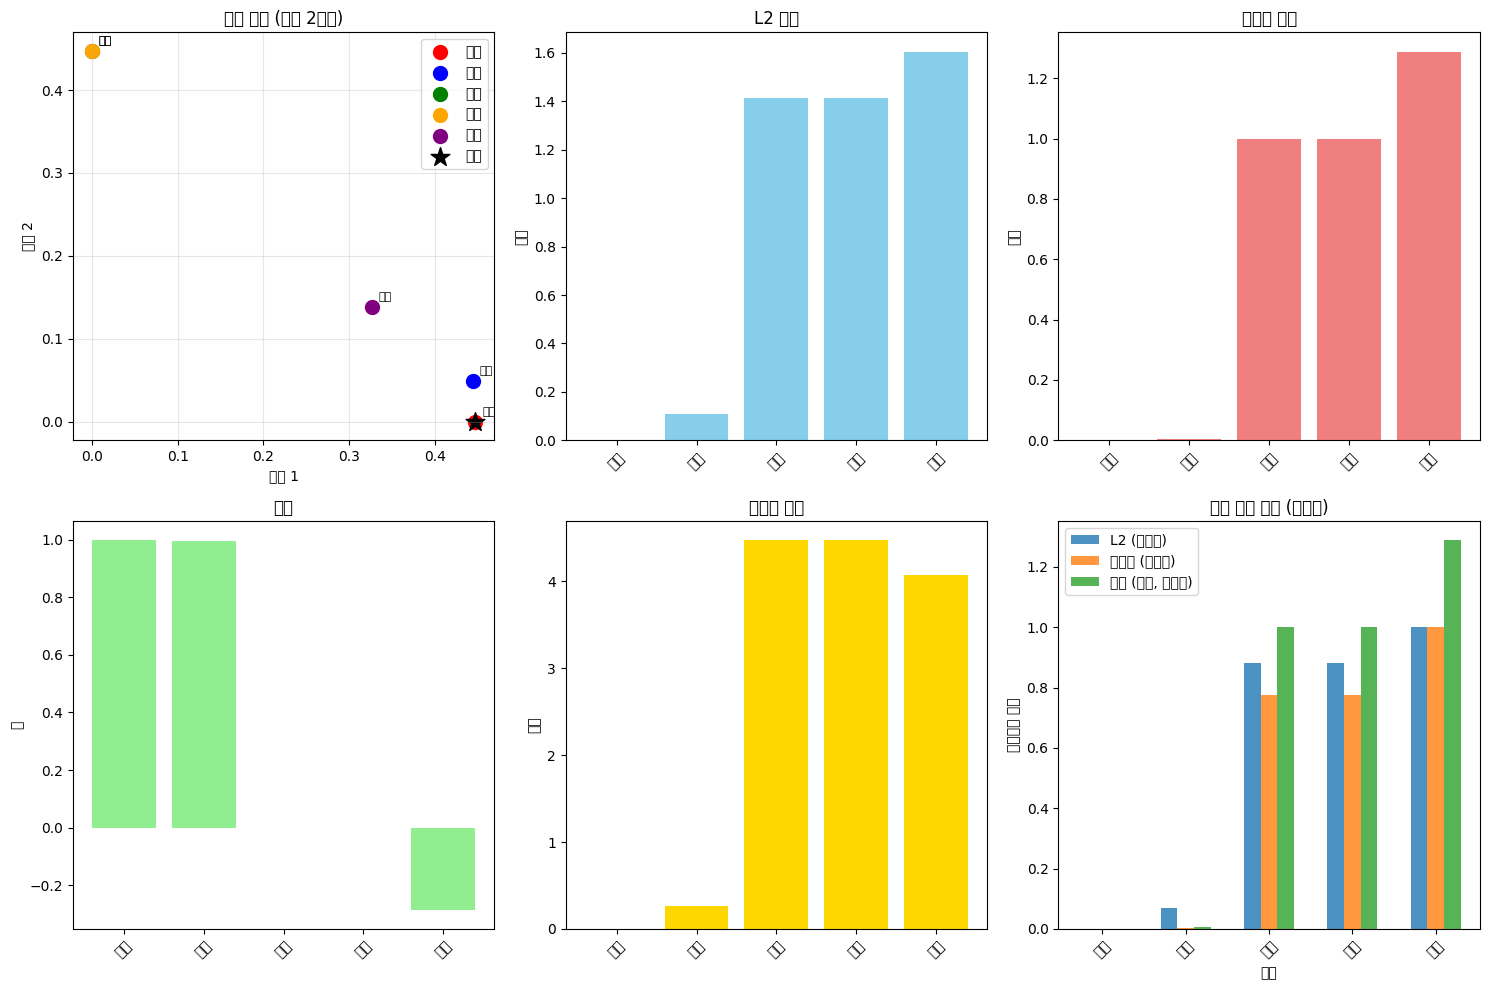


💡 거리 함수 특징 요약:
   🔹 L2 거리: 벡터 간 실제 기하학적 거리, 크기에 민감
   🔹 코사인 거리: 벡터 간 각도 측정, 크기 무관
   🔹 내적: 벡터 크기와 각도 모두 고려
   🔹 맨하탄 거리: 각 차원별 차이의 절댓값 합


In [15]:
def compare_distance_functions():
    """다양한 벡터 거리 계산 함수들을 비교하고 시각화합니다."""
    
    # 1. 샘플 벡터들 생성
    print("🧮 벡터 거리 함수 비교 및 분석")
    print("=" * 50)
    
    # 다양한 패턴의 벡터 생성
    dim = 10  # 시각화를 위해 작은 차원 사용
    
    # 기준 벡터
    base_vector = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
    
    # 비교할 벡터들
    vectors = {
        '동일': np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]),
        '유사': np.array([0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1]),
        '반대': np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]),
        '직교': np.array([0, 1, 0, -1, 0, 1, 0, -1, 0, 1]),
        '랜덤': np.random.normal(0, 1, dim)
    }
    
    # 벡터들을 정규화
    base_vector = base_vector / np.linalg.norm(base_vector)
    for name in vectors:
        vectors[name] = vectors[name] / np.linalg.norm(vectors[name])
    
    print(f"🎯 기준 벡터: {base_vector}")
    print("\n📊 거리 계산 결과:")
    print("-" * 80)
    print(f"{'벡터 이름':<10} {'L2 거리':<12} {'코사인 거리':<14} {'내적':<12} {'맨하탄 거리':<12}")
    print("-" * 80)
    
    distance_results = []
    
    for name, vector in vectors.items():
        # L2 거리 (유클리드 거리)
        l2_dist = np.linalg.norm(base_vector - vector)
        
        # 코사인 거리 (1 - 코사인 유사도)
        cosine_sim = np.dot(base_vector, vector)
        cosine_dist = 1 - cosine_sim
        
        # 내적
        inner_product = np.dot(base_vector, vector)
        
        # 맨하탄 거리 (L1 거리)
        manhattan_dist = np.sum(np.abs(base_vector - vector))
        
        print(f"{name:<10} {l2_dist:<12.4f} {cosine_dist:<14.4f} {inner_product:<12.4f} {manhattan_dist:<12.4f}")
        
        distance_results.append({
            'name': name,
            'vector': vector,
            'l2': l2_dist,
            'cosine': cosine_dist,
            'inner': inner_product,
            'manhattan': manhattan_dist
        })
    
    # 2. PostgreSQL에서 거리 함수 테스트
    print("\n🔍 PostgreSQL pgvector 거리 함수 테스트")
    conn = get_db_connection()
    
    if conn:
        try:
            cursor = conn.cursor()
            
            # 테스트용 벡터 데이터 임시 테이블 생성
            cursor.execute("DROP TABLE IF EXISTS temp_vectors;")
            cursor.execute("""
                CREATE TEMPORARY TABLE temp_vectors (
                    name VARCHAR(20),
                    vector_data VECTOR(10)
                );
            """)
            
            # 테스트 벡터들 삽입
            for name, vector in vectors.items():
                cursor.execute(
                    "INSERT INTO temp_vectors (name, vector_data) VALUES (%s, %s);",
                    (name, vector.tolist())
                )
            
            base_vector_list = base_vector.tolist()
            
            print("\n🗄️  PostgreSQL 거리 계산 결과:")
            print("-" * 70)
            print(f"{'벡터 이름':<10} {'L2 거리':<12} {'코사인 거리':<14} {'내적':<12}")
            print("-" * 70)
            
            cursor.execute("""
                SELECT name,
                       vector_data <-> %s::vector as l2_distance,
                       vector_data <=> %s::vector as cosine_distance,
                       (vector_data <#> %s::vector) * -1 as inner_product
                FROM temp_vectors
                ORDER BY name;
            """, (base_vector_list, base_vector_list, base_vector_list))
            
            for name, l2, cosine, inner in cursor.fetchall():
                print(f"{name:<10} {l2:<12.4f} {cosine:<14.4f} {inner:<12.4f}")
            
            conn.close()
            
        except Exception as e:
            print(f"❌ PostgreSQL 테스트 실패: {e}")
            conn.close()
    
    # 3. 거리 함수별 순위 비교
    print("\n🏆 거리 함수별 유사도 순위 (기준 벡터와 가장 유사한 순)")
    print("-" * 60)
    
    # L2 거리 순위 (작을수록 유사)
    l2_ranking = sorted(distance_results, key=lambda x: x['l2'])
    print("L2 거리 순위:")
    for i, result in enumerate(l2_ranking, 1):
        print(f"   {i}. {result['name']} (거리: {result['l2']:.4f})")
    
    # 코사인 거리 순위 (작을수록 유사)
    cosine_ranking = sorted(distance_results, key=lambda x: x['cosine'])
    print("\n코사인 거리 순위:")
    for i, result in enumerate(cosine_ranking, 1):
        print(f"   {i}. {result['name']} (거리: {result['cosine']:.4f})")
    
    # 내적 순위 (클수록 유사)
    inner_ranking = sorted(distance_results, key=lambda x: x['inner'], reverse=True)
    print("\n내적 순위:")
    for i, result in enumerate(inner_ranking, 1):
        print(f"   {i}. {result['name']} (내적: {result['inner']:.4f})")
    
    # 4. 시각화
    plt.figure(figsize=(15, 10))
    
    # 서브플롯 1: 벡터 시각화 (처음 2차원만)
    plt.subplot(2, 3, 1)
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, (name, vector) in enumerate(vectors.items()):
        plt.scatter(vector[0], vector[1], c=colors[i], label=name, s=100)
        plt.annotate(name, (vector[0], vector[1]), xytext=(5, 5), 
                    textcoords='offset points', fontsize=8)
    plt.scatter(base_vector[0], base_vector[1], c='black', marker='*', 
               s=200, label='기준')
    plt.xlabel('차원 1')
    plt.ylabel('차원 2')
    plt.title('벡터 분포 (처음 2차원)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 서브플롯 2: L2 거리
    plt.subplot(2, 3, 2)
    names = [r['name'] for r in distance_results]
    l2_distances = [r['l2'] for r in distance_results]
    plt.bar(names, l2_distances, color='skyblue')
    plt.title('L2 거리')
    plt.ylabel('거리')
    plt.xticks(rotation=45)
    
    # 서브플롯 3: 코사인 거리
    plt.subplot(2, 3, 3)
    cosine_distances = [r['cosine'] for r in distance_results]
    plt.bar(names, cosine_distances, color='lightcoral')
    plt.title('코사인 거리')
    plt.ylabel('거리')
    plt.xticks(rotation=45)
    
    # 서브플롯 4: 내적
    plt.subplot(2, 3, 4)
    inner_products = [r['inner'] for r in distance_results]
    plt.bar(names, inner_products, color='lightgreen')
    plt.title('내적')
    plt.ylabel('값')
    plt.xticks(rotation=45)
    
    # 서브플롯 5: 맨하탄 거리
    plt.subplot(2, 3, 5)
    manhattan_distances = [r['manhattan'] for r in distance_results]
    plt.bar(names, manhattan_distances, color='gold')
    plt.title('맨하탄 거리')
    plt.ylabel('거리')
    plt.xticks(rotation=45)
    
    # 서브플롯 6: 거리 함수 비교
    plt.subplot(2, 3, 6)
    x = np.arange(len(names))
    width = 0.2
    
    # 정규화된 거리들 (0-1 범위로)
    l2_norm = np.array(l2_distances) / max(l2_distances)
    cosine_norm = np.array(cosine_distances) / max(cosine_distances)
    inner_norm = 1 - (np.array(inner_products) / max(inner_products))  # 역순
    
    plt.bar(x - width, l2_norm, width, label='L2 (정규화)', alpha=0.8)
    plt.bar(x, cosine_norm, width, label='코사인 (정규화)', alpha=0.8)
    plt.bar(x + width, inner_norm, width, label='내적 (역순, 정규화)', alpha=0.8)
    
    plt.xlabel('벡터')
    plt.ylabel('정규화된 거리')
    plt.title('거리 함수 비교 (정규화)')
    plt.xticks(x, names, rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 거리 함수 특징 요약:")
    print("   🔹 L2 거리: 벡터 간 실제 기하학적 거리, 크기에 민감")
    print("   🔹 코사인 거리: 벡터 간 각도 측정, 크기 무관")
    print("   🔹 내적: 벡터 크기와 각도 모두 고려")
    print("   🔹 맨하탄 거리: 각 차원별 차이의 절댓값 합")

# 벡터 거리 함수 비교 실행
compare_distance_functions()

## 9. 실제 문서 임베딩 예제

In [17]:
def document_embedding_example():
    """실제 문서를 임베딩하여 벡터 데이터베이스에 저장하고 검색하는 예제"""
    
    try:
        # sentence-transformers 설치 확인 및 설치
        import json
        import sys
        import subprocess
        
        try:
            from sentence_transformers import SentenceTransformer
        except ImportError:
            print("📦 sentence-transformers 설치 중...")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'sentence-transformers'])
            from sentence_transformers import SentenceTransformer
        
        print("📄 실제 문서 임베딩 및 검색 예제")
        print("=" * 50)
        
        # 임베딩 모델 로드 (작은 모델 사용)
        print("🤖 임베딩 모델 로드 중...")
        model = SentenceTransformer('all-MiniLM-L6-v2')  # 384차원 임베딩
        
        # 샘플 문서들
        documents = [
            {
                'title': 'PostgreSQL 소개',
                'content': 'PostgreSQL은 강력한 오픈소스 객체-관계형 데이터베이스 시스템입니다. 30년 이상의 활발한 개발을 통해 안정성, 기능 완성도, 성능 면에서 강력한 명성을 얻었습니다.',
                'metadata': {'category': 'database', 'language': 'korean', 'source': 'manual'}
            },
            {
                'title': 'pgvector 확장',
                'content': 'pgvector는 PostgreSQL에서 벡터 유사도 검색을 가능하게 하는 확장입니다. 머신러닝 임베딩을 저장하고 검색할 수 있습니다.',
                'metadata': {'category': 'extension', 'language': 'korean', 'source': 'documentation'}
            },
            {
                'title': '벡터 데이터베이스 개념',
                'content': '벡터 데이터베이스는 고차원 벡터 데이터를 효율적으로 저장하고 검색하는 데이터베이스입니다. 임베딩 벡터 간의 유사도를 계산하여 의미적으로 유사한 데이터를 찾을 수 있습니다.',
                'metadata': {'category': 'concept', 'language': 'korean', 'source': 'tutorial'}
            },
            {
                'title': '머신러닝과 임베딩',
                'content': '임베딩은 텍스트, 이미지, 오디오 등의 데이터를 고차원 벡터 공간에 매핑하는 기술입니다. 유사한 의미를 가진 데이터는 벡터 공간에서 가까운 위치에 배치됩니다.',
                'metadata': {'category': 'ai', 'language': 'korean', 'source': 'research'}
            },
            {
                'title': 'Database Indexing',
                'content': 'Database indexing is a data structure technique to efficiently retrieve records from database tables. B-tree, hash, and vector indexes are common types used to speed up query performance.',
                'metadata': {'category': 'database', 'language': 'english', 'source': 'textbook'}
            },
            {
                'title': 'Vector Similarity Search',
                'content': 'Vector similarity search finds the most similar vectors to a query vector using distance metrics like cosine similarity, Euclidean distance, or dot product. This is fundamental to recommendation systems and semantic search.',
                'metadata': {'category': 'algorithm', 'language': 'english', 'source': 'research'}
            },
            {
                'title': 'Natural Language Processing',
                'content': 'NLP combines computational linguistics with statistical and machine learning methods to give computers the ability to understand human language. Modern NLP heavily relies on transformer models and embeddings.',
                'metadata': {'category': 'ai', 'language': 'english', 'source': 'academic'}
            },
            {
                'title': '딥러닝과 트랜스포머',
                'content': '트랜스포머 아키텍처는 자연어 처리 분야를 혁신했습니다. BERT, GPT와 같은 모델들이 트랜스포머를 기반으로 하며, 텍스트를 의미있는 벡터로 변환할 수 있습니다.',
                'metadata': {'category': 'ai', 'language': 'korean', 'source': 'research'}
            }
        ]
        
        # 문서 임베딩 생성
        print("🔄 문서 임베딩 생성 중...")
        embeddings = []
        for doc in documents:
            # 제목과 내용을 결합하여 임베딩
            text = f"{doc['title']} {doc['content']}"
            embedding = model.encode(text)
            embeddings.append(embedding.tolist())
            print(f"   ✅ '{doc['title']}' 임베딩 완료 (차원: {len(embedding)})")
        
        # 데이터베이스에 저장
        conn = get_db_connection()
        if not conn:
            return
        
        try:
            cursor = conn.cursor()
            
            # 기존 문서 데이터 삭제
            cursor.execute("DELETE FROM vector_documents;")
            
            print("\n💾 데이터베이스에 문서 저장 중...")
            for i, doc in enumerate(documents):
                cursor.execute("""
                    INSERT INTO vector_documents (title, content, embedding, metadata)
                    VALUES (%s, %s, %s, %s)
                """, (
                    doc['title'],
                    doc['content'],
                    embeddings[i],
                    json.dumps(doc['metadata'])
                ))
            
            cursor.execute("SELECT COUNT(*) FROM vector_documents;")
            doc_count = cursor.fetchone()[0]
            print(f"✅ {doc_count}개 문서 저장 완료!")
            
            # 검색 인덱스 생성
            print("\n🔍 검색 성능 향상을 위한 인덱스 생성...")
            cursor.execute("DROP INDEX IF EXISTS doc_embedding_idx;")
            cursor.execute("""
                CREATE INDEX doc_embedding_idx ON vector_documents 
                USING hnsw (embedding vector_cosine_ops) 
                WITH (m = 16, ef_construction = 64);
            """)
            print("✅ HNSW 인덱스 생성 완료!")
            
            conn.commit()
            
            # 검색 테스트
            print("\n🔍 의미 검색 테스트")
            print("-" * 40)
            
            search_queries = [
                "데이터베이스 시스템",
                "벡터 검색 알고리즘",
                "인공지능과 머신러닝",
                "database performance"
            ]
            
            for query in search_queries:
                print(f"\n🔎 검색어: '{query}'")
                
                # 쿼리 임베딩 생성
                query_embedding = model.encode(query).tolist()
                
                # 유사 문서 검색
                cursor.execute("""
                    SELECT title, 
                           1 - (embedding <=> %s::vector) as similarity,
                           metadata->>'category' as category,
                           metadata->>'language' as language
                    FROM vector_documents
                    ORDER BY embedding <=> %s::vector
                    LIMIT 3;
                """, (query_embedding, query_embedding))
                
                results = cursor.fetchall()
                
                for i, (title, similarity, category, language) in enumerate(results, 1):
                    print(f"   {i}. {title} ({category}, {language})")
                    print(f"      유사도: {similarity:.4f}")
            
            # 카테고리별 검색
            print("\n📂 카테고리별 검색 (AI 카테고리)")
            print("-" * 40)
            
            query = "머신러닝 모델"
            query_embedding = model.encode(query).tolist()
            
            cursor.execute("""
                SELECT title, content,
                       1 - (embedding <=> %s::vector) as similarity,
                       metadata->>'language' as language
                FROM vector_documents
                WHERE metadata->>'category' = 'ai'
                ORDER BY embedding <=> %s::vector
                LIMIT 3;
            """, (query_embedding, query_embedding))
            
            results = cursor.fetchall()
            
            for i, (title, content, similarity, language) in enumerate(results, 1):
                print(f"\n{i}. {title} ({language})")
                print(f"   유사도: {similarity:.4f}")
                print(f"   내용: {content[:100]}...")
            
            # 언어별 검색 통계
            print("\n📊 저장된 문서 통계")
            print("-" * 30)
            
            cursor.execute("""
                SELECT metadata->>'category' as category,
                       metadata->>'language' as language,
                       COUNT(*) as count
                FROM vector_documents
                GROUP BY category, language
                ORDER BY category, language;
            """)
            
            stats = cursor.fetchall()
            for category, language, count in stats:
                print(f"   {category} ({language}): {count}개")
            
            conn.close()
            
        except Exception as e:
            print(f"❌ 데이터베이스 작업 실패: {e}")
            conn.rollback()
            conn.close()
            
    except Exception as e:
        print(f"❌ 문서 임베딩 예제 실패: {e}")
        
    print("\n💡 실제 활용 팁:")
    print("   🔹 더 큰 모델 사용 시 검색 품질 향상 (예: all-mpnet-base-v2)")
    print("   🔹 도메인 특화 모델 사용 시 전문 분야 검색 성능 향상")
    print("   🔹 다국어 모델 사용 시 언어간 의미 검색 가능")
    print("   🔹 배치 처리로 대량 문서 임베딩 효율화")

# 문서 임베딩 예제 실행
document_embedding_example()

📄 실제 문서 임베딩 및 검색 예제
🤖 임베딩 모델 로드 중...
🔄 문서 임베딩 생성 중...
   ✅ 'PostgreSQL 소개' 임베딩 완료 (차원: 384)
   ✅ 'pgvector 확장' 임베딩 완료 (차원: 384)
   ✅ '벡터 데이터베이스 개념' 임베딩 완료 (차원: 384)
   ✅ '머신러닝과 임베딩' 임베딩 완료 (차원: 384)
   ✅ 'Database Indexing' 임베딩 완료 (차원: 384)
   ✅ 'Vector Similarity Search' 임베딩 완료 (차원: 384)
   ✅ 'Natural Language Processing' 임베딩 완료 (차원: 384)
   ✅ '딥러닝과 트랜스포머' 임베딩 완료 (차원: 384)

💾 데이터베이스에 문서 저장 중...
✅ 8개 문서 저장 완료!

🔍 검색 성능 향상을 위한 인덱스 생성...
✅ HNSW 인덱스 생성 완료!

🔍 의미 검색 테스트
----------------------------------------

🔎 검색어: '데이터베이스 시스템'
   1. 머신러닝과 임베딩 (ai, korean)
      유사도: 0.4973
   2. 벡터 데이터베이스 개념 (concept, korean)
      유사도: 0.4361
   3. 딥러닝과 트랜스포머 (ai, korean)
      유사도: 0.4045

🔎 검색어: '벡터 검색 알고리즘'
   1. 머신러닝과 임베딩 (ai, korean)
      유사도: 0.5472
   2. 벡터 데이터베이스 개념 (concept, korean)
      유사도: 0.5038
   3. 딥러닝과 트랜스포머 (ai, korean)
      유사도: 0.3958

🔎 검색어: '인공지능과 머신러닝'
   1. 머신러닝과 임베딩 (ai, korean)
      유사도: 0.7743
   2. 벡터 데이터베이스 개념 (concept, korean)
      유사도: 0.6919
   3. PostgreSQL 소개 (da

## 10. 결론 및 추가 학습 자료

🎉 PostgreSQL + pgvector 벡터 데이터베이스 실습 완료!
============================================================

📚 학습한 내용:
   ✅ PostgreSQL과 pgvector 확장 설정
   ✅ 벡터 데이터 타입과 테이블 생성
   ✅ 다양한 패턴의 벡터 데이터 생성 및 삽입
   ✅ L2, 코사인, 내적 거리 함수 비교
   ✅ IVFFlat, HNSW 인덱스 생성 및 성능 최적화
   ✅ 실제 문서 임베딩을 통한 의미 검색
   ✅ 메타데이터 필터링 및 카테고리별 검색

🚀 PostgreSQL + pgvector의 장점:
   🔹 ACID 트랜잭션 지원으로 데이터 일관성 보장
   🔹 SQL과 벡터 연산의 원활한 결합
   🔹 다양한 벡터 인덱스 옵션 (IVFFlat, HNSW)
   🔹 높은 확장성과 엔터프라이즈급 안정성
   🔹 풍부한 PostgreSQL 생태계 활용 가능
   🔹 복잡한 조인과 집계 연산 지원

💼 실제 활용 사례:
   📄 문서 검색 및 추천 시스템
   🛒 상품 추천 및 유사 상품 검색
   🔍 의미 기반 검색 엔진
   🤖 챗봇 및 FAQ 시스템
...
   SQL의 표현력과 벡터 검색의 혁신을 함께 활용하여
   차세대 AI 애플리케이션을 구축해보세요!

🚀 Happy Vector Searching with PostgreSQL! 🚀